
<br>
<br>
<br>
<br>
<br>
<br>

# <center>Building a product recommendation engine for H&M </center>
## <center>Ujas Shah</center>
## <center>April 4th, 2022</center>

### GitHub link: www.github.com

## Abstract
This project tries to build a product recommendation engine for the fashion retailer H&M. All the data used in the project was provided by H&M and is hosted on their Kaggle competition page. This document is designed to be an introduction to recommendation systems with matrix factorization, particularly, it looks at the Funk-SVD technique. I try to provide some mathematical background and intuition for how the technique works. I then apply a variation of the technique with the help of deep learning using Keras.
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# Introduction

## Problem statement
**To create a system to provide personalized product recommendations for H&M customers.**

H&M, the Swedish fashion giant, hosted a competition on Kaggle from January-May 2022 with the primary goal of providing better presonalized product recommendations to their customers of products they would want to buy. Product recommendations become extremely important as a company's offerings grow in size. This is becuase:
*   With a large number of offerings, a recommendation system would help customers get to products they would like easily. Hence, avoiding a situation where customers might be put off from making a purchase owing to inability to find what they are looking for.
*   Personalised recommendations would also help a company host customers with a multitude of tastes and catering to each of them individually, rather than suggesting everyone the same most bought products.
*   Furthermore, better recommendations would help in reducing the carbon footprint of the company by recommending products apt for a customer and thereby reducing returns and customer dissatisfaction.

## The data

H&M provided 4 main files that made up the dataset. They are
* Images- A set containing images of all products
* Articles- A csv file containing details of articles sold on the website; with columns- article id, product name, product group name, apperance and color.
* Customers- A csv file containing details of customers; with columns customer id, member status, fashion news recieptient, age and postal code.
* Transactions- A csv file containting details of transactions; with columns- transaction date, customer id, article id, price and sales channel.

While we have all of this data, as this document will be an introduction to recommendation systems, I will be using only a small subset of it to create a model, specifically, I will be using customer id and article id pairs from the transactions dataset.


## Evaluation metric

12 predictions are to be made for each customer. Once the predictions are made, they are evaluated by the Mean Average Prediction @ 12 (MAP@12) which is described below.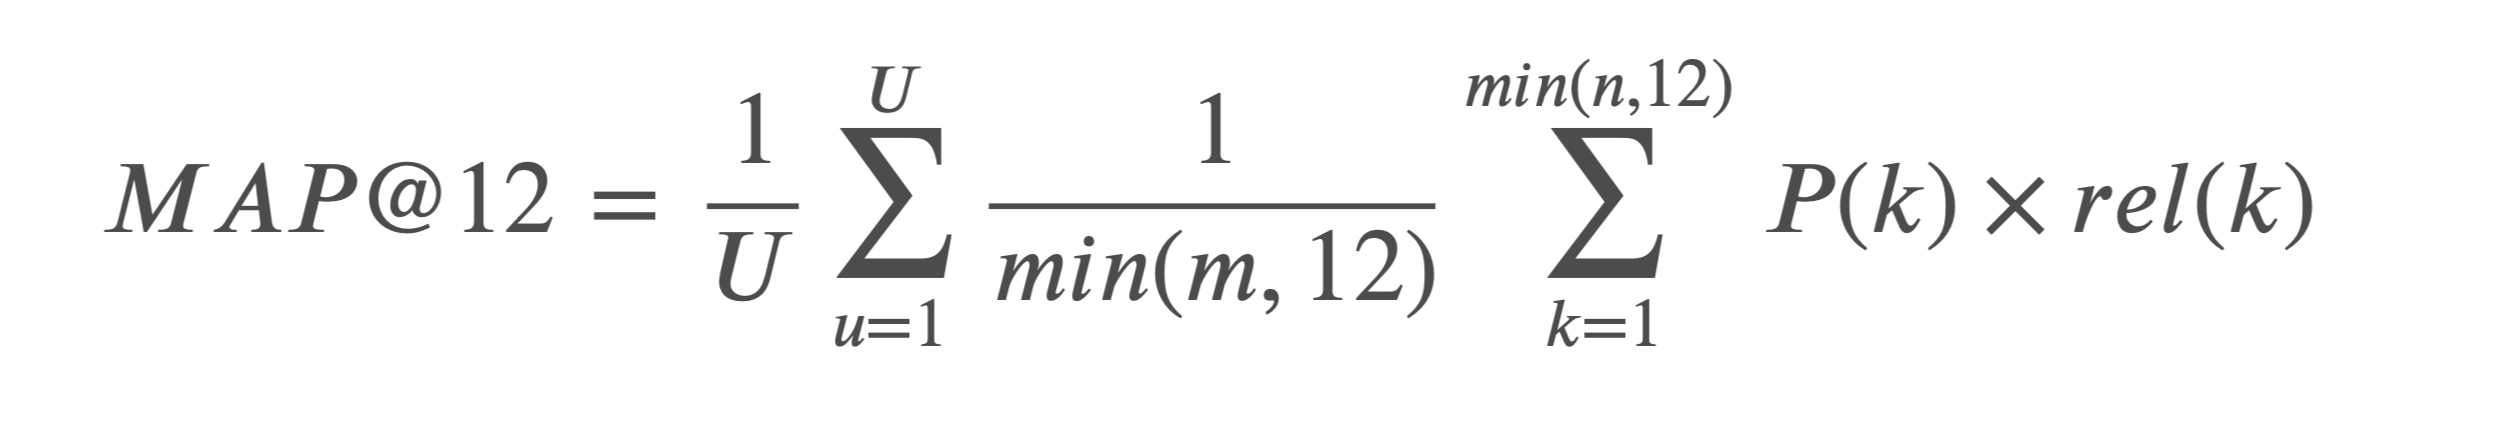

where U is the number of customers,P(k) is the precision at cutoff k, n is the number predictions per customer, m is the number of ground truth values per customer, and rel(k) is an indicator function equaling 1 if the item at rank k is a relevant (correct) label, zero otherwise.

# Installing and loading libaries; and preparing the data

In [ ]:
# pip install plot_keras_history

In [20]:
import random
import pandas as pd
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
from tensorflow import keras
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Below I will drop columns of the loaded datasets, in order to save memory for future use.

In [ ]:
customers = pd.read_csv('/content/drive/MyDrive/customers.csv')
customers.drop(columns=['FN','Active','club_member_status',
                        'fashion_news_frequency','age','postal_code'], 
               inplace = True)
customers

,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...
...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...


In [ ]:
# I can reimport this file later to save memory for the rest of the project

customers.to_csv('/content/drive/MyDrive/customers_small.csv', index=False)

In [ ]:
transactions = pd.read_csv(
    '/content/drive/MyDrive/transactions_train_small.csv')
transactions.drop(columns='Unnamed: 0', inplace=True)
transactions

In [ ]:
# I will now also save the reduced transactions file,
# so that I can load it again with it using less ram.

transactions.to_csv('/content/drive/MyDrive/transactions_train.csv', 
                    index=False)

# Data cleaning 

In [ ]:
#While doing this we find that the customers set have about 10000 customers 
# that are not present in the transactions set, but on which we are expected 
# to predict. We'll create that list of customers here and add it up later on.

len(set(customers.customer_id)- set(transactions.customer_id))

In [22]:
#I will now restart my kernel and load the reduced data sets, and make the 
# list of customers not in the transactions list again.

customers = pd.read_csv('/content/drive/MyDrive/customers_small.csv')
transactions = pd.read_csv('/content/drive/MyDrive/transactions_train.csv')
customers_sans_transactions = set(customers.customer_id)-set(transactions.customer_id)

print(customers.head())
print(transactions.head())

                                         customer_id
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...
                                         customer_id  article_id
0  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001
1  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023
2  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004
3  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003
4  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004


In [17]:
#Checking for NA values

print(transactions.article_id.isna().sum())
print(transactions.customer_id.isna().sum())
print(customers.customer_id.isna().sum())

0
0
0


In [23]:
#encoding article id and customer id values as it will be usefull later

encoded= {}

le = preprocessing.LabelEncoder()
le.fit(customers.customer_id)
transactions.customer_id = le.transform(transactions.customer_id)
encoded['customers'] = le

le = preprocessing.LabelEncoder()
transactions.article_id = le.fit_transform(transactions.article_id)
encoded['articles'] = le

transactions = transactions.assign(numbers = np.ones(len(transactions)))
transactions.sort_values(by=['customer_id', 'article_id'], inplace = True)

transactions = transactions.groupby(by=['customer_id', 'article_id'], 
                                    as_index=False, sort=False).sum()

transactions.head()

,customer_id,article_id,numbers
0,0,99,1.0
1,0,15980,2.0
2,0,16000,1.0
3,0,23967,1.0
4,0,29482,1.0


# Recommendations with matrix factorisation

Recommendation systems can make recommendations through two fundamental ways. The first one being content based filtering and the second being collaborative filtering.

## Content based filtering

Content based filtering is when one recommends new products to a customer based on what they have bought previosly. Essentially recommending products that are similar to the products that the customer has already bought. While this is a decent way to start, we would hit the limitations of this method pretty quickly.

* In this technique, we end up only recommending products catering to the revealed preferences of the customer and hence there is little scope of our recommendations to actually cater to their full scale of preferences.
* Furthermore, as this method recommends products based on their similarity, we need some kind of tags that represent the product's features to identify similar ones. This may often require us to hand-engineer features.

## Collaborative filtering

The weaknesses of the content based filtering method are addressed by the collaborative filtering method.

* This method is able to make recommendations of similar products to what the user is already using, like content based filtering, but it is also able to make recommendations based on what similar users have bought as well.
* This method doesn't require us to hand-engineer features as it implicitly learns features of products based on their appearances in a matrix.

The matrix here is one with customers as rows and articles as columns, with the particular indices being a number that represents whether the customer has purchased the product or not.

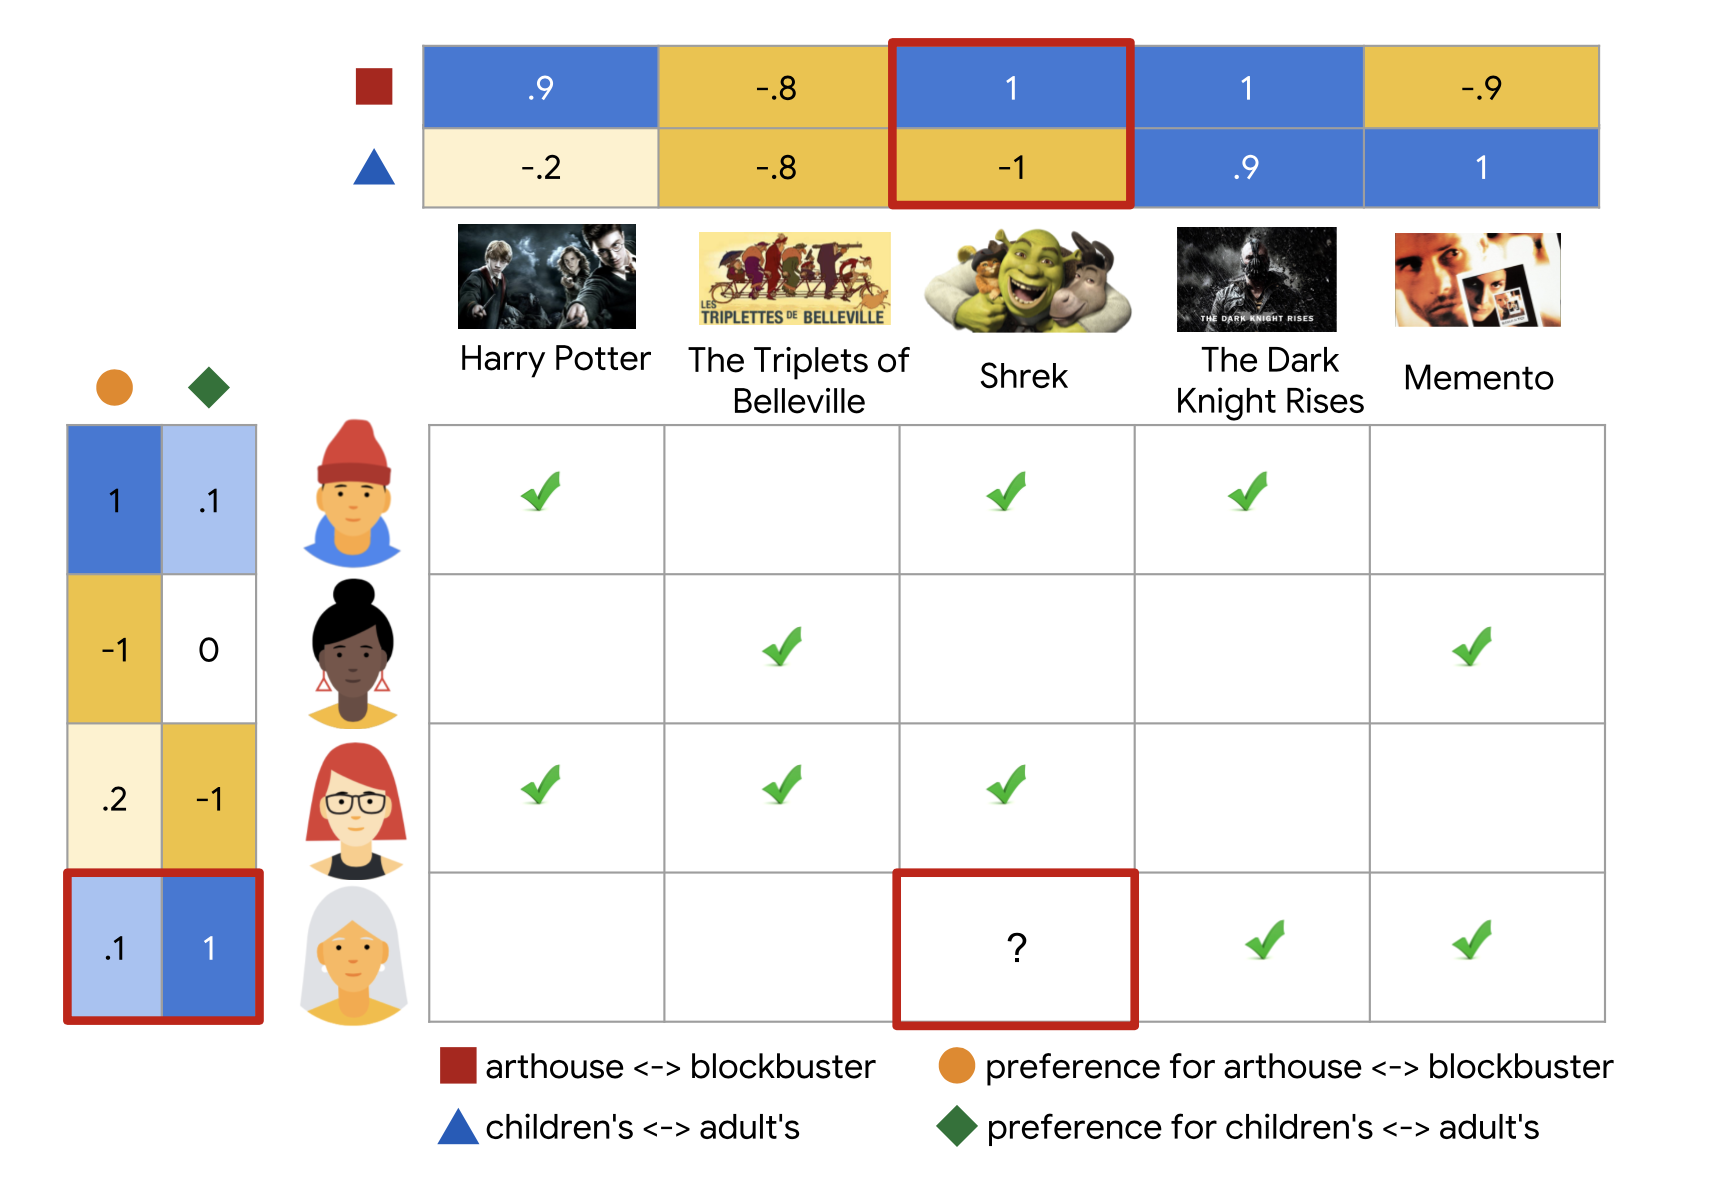

Here each customer and article is represented by a vector of numbers, called embeddings. See picture, credits- Google 

Embeddings are crucial here as they are the basis on which matrix factorization works. The aim is to make the customer and article embeddings such that when we take a dot product of the any two, they result in a scalar at their intersection within the matrix; that here signifies whether that customer has bought that product.

How do we get the the embeddings to have this property? Through matrix factorization.

Matrix factorization refers to the process to trying to factorize the transactions matrix we were talking about above (with customers as rows and articles as columns) into two other matrices, the customer embedding matrix and the article embedding matrix. Such that, when we then matrix multiply those two matrices we get the transactions matrix again.

One must keep in mind that the transactions matrix is extremely sparse as customers would have bought only a very small portion of the total articles on sale. Hence one way to do this would be randomly intialize the two factorized matrices and then multiply the two to try to get the transactions matrix. Then using the difference in the observed values of real and the approximated transactions matrix iteratively ture the embeddings of the customer and article embedding matrices through gradient descent.

# Defining a function to make predictions

This is a significant part of this task owing to the size of the dataset being dealt with. Below I make a function, that would take in the article and customer embeddings and give out the top 12 recommendations of products that have not already been bought by the customer.

In [24]:
def get_predictions(article_embeddings, customer_embeddings, transac):
  
  preds = pd.DataFrame()

# multiplying a section of the customer embeddings with article embeddings,
# to save memory. With this we get the likeliness of a customer buying all
# different articles.
  for i in range(0,len(customer_embeddings), 1000):
    b = np.matmul(customer_embeddings[i:i+1000], 
                  np.transpose(article_embeddings))

# Next we need to put values of the above created matrix that have already
# been bought to zero, so we do not end up recommening it again.
    range_put_zero = transac.customer_id.searchsorted([i,i+1000])
    put_zero = transac[range_put_zero[0]:
                       range_put_zero[1]][['customer_id',
                                           'article_id']].values
    put_zero[:,0] = put_zero[:,0]-i

    b[tuple(put_zero.T)]=0

# In the below code we select the top 12 recommendations of all products
# for each customer.
    a = b.argpartition(-12)[:,-12:]
    preds = preds.append(pd.DataFrame(
        np.take_along_axis(a, 
                           np.take_along_axis(b, 
                                              a, axis =1).argsort(), axis=1)))

  preds.reset_index(inplace=True, drop=True)
  preds.reset_index(inplace=True)

# converting predictions to back to customer and article ids as given by H&M
  preds['customer_id'] = encoded['customers'].inverse_transform(
      np.array(preds['index']))

  for i in range(12):
    preds[i] = encoded['articles'].inverse_transform(
        np.array(np.array(preds[i])))

  preds = preds.astype('str')

  preds['prediction'] = preds[[0, 1, 2, 3, 4, 5, 6, 7, 
                               8, 9, 10, 11]].agg(' '.join, axis=1)
  preds.drop(columns=['index', 0, 1, 2, 3, 4, 5, 6, 7, 
                      8, 9, 10, 11], inplace=True)

  return(preds)

Now we have our data, concept and prediction function ready for a first model, we will use slight variation of what has been mentioned above and implement this algorithm in a deep learning framework. This is done as the coding is significanly more accesible compared to a conventional matrix factorization algorithm.

# Model 1 with actual transactions and simple MSE

In [25]:
# Building the model
a_input1 = keras.Input(shape=(1,))
c_input1 = keras.Input(shape=(1,))

a_embedding1 = keras.layers.Embedding(input_dim=len(set(
    transactions.article_id)),output_dim=100)(a_input1)
c_embedding1 = keras.layers.Embedding(input_dim=len(set(
    customers.customer_id)),output_dim=100)(c_input1)

c_reshape1 = keras.layers.Reshape((100,1))(c_embedding1)
a_reshape1 = keras.layers.Reshape((100,1))(a_embedding1)

dot1 = keras.layers.Dot(axes=(1,1))([a_reshape1, c_reshape1])

model1 = keras.models.Model([a_input1, c_input1], dot1)

model1.compile(optimizer=keras.optimizers.Adam(), 
               loss=tf.keras.losses.MeanSquaredError())

model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 100)       10454700    ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 100)       137198000   ['input_4[0][0]']                
                                                                                            

In [26]:
# Fitting the model
history1 = model1.fit(x=[transactions.article_id,transactions.customer_id], 
                      y=[transactions.numbers], batch_size=10000, epochs = 25)

Epoch 1/25
2731/2731 [==============================] - 103s 37ms/step - loss: 0.8973
Epoch 2/25
2731/2731 [==============================] - 102s 37ms/step - loss: 0.3138
Epoch 3/25
2731/2731 [==============================] - 103s 38ms/step - loss: 0.2594
Epoch 4/25
2731/2731 [==============================] - 102s 37ms/step - loss: 0.2095
Epoch 5/25
2731/2731 [==============================] - 102s 37ms/step - loss: 0.1703
Epoch 6/25
2731/2731 [==============================] - 101s 37ms/step - loss: 0.1415
Epoch 7/25
2731/2731 [==============================] - 102s 37ms/step - loss: 0.1206
Epoch 8/25
2731/2731 [==============================] - 102s 38ms/step - loss: 0.1053
Epoch 9/25
2731/2731 [==============================] - 102s 37ms/step - loss: 0.0934
Epoch 10/25
2731/2731 [==============================] - 102s 37ms/step - loss: 0.0842
Epoch 11/25
2731/2731 [==============================] - 103s 38ms/step - loss: 0.0768
Epoch 12/25
2731/2731 [=============================

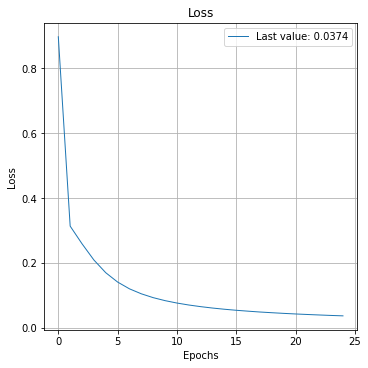

In [27]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [28]:
# Copying customer and article embeddings
article_embeddings1 = model1.layers[2].get_weights()[0]
customer_embeddings1 = model1.layers[3].get_weights()[0]

print('Article embeddings \n', article_embeddings1[:5,:5])
print('Customer embeddings \n',customer_embeddings1[:5,:5])

Article embeddings 
 [[ 3.3505496e-01  1.7097554e-01 -2.9873434e-01  4.3597350e-01
   4.2094523e-01]
 [ 3.2805598e-01 -2.6928836e-01 -2.1568006e-01 -2.1377960e-01
   2.9700488e-01]
 [ 6.3867316e-02 -5.8266389e-01 -5.2017158e-01  2.1050304e-04
   2.7197574e-03]
 [ 2.5723958e-01 -6.1663266e-02  2.0928366e-02  4.6508349e-02
   1.4779961e-01]
 [ 5.2159458e-01  2.9872301e-01  1.8713540e-01  9.4517224e-02
   3.7411872e-01]]
Customer embeddings 
 [[ 0.16175248 -0.05550563 -0.17246851 -0.04744853  0.13755088]
 [-0.3779002   0.21887761  0.4042105   0.39149597  0.22094569]
 [ 0.2280754  -0.18808585 -0.14703438  0.05215196  0.23135118]
 [ 0.00129409 -0.10141418 -0.08344115  0.04313248  0.08948693]
 [ 0.11114056 -0.09377705 -0.07866967  0.01213071  0.1869741 ]]


In [29]:
# Getting predictions made by ths model with the function created earlier.
preds1 = get_predictions(article_embeddings1, 
                        customer_embeddings1, transactions)
preds1

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,678342001 828047002 685813001 707061001 689365...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,717464001 803118001 607642008 123173001 228257...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,690692003 626415015 507909001 633608001 331474...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,620216036 828047002 554141018 605704002 691695...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,689365047 751471042 456163028 732191001 707061...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,702366001 732191001 682050002 228257001 706931...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,633608001 605842010 708531001 707061001 678342...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,593829001 685816001 620216036 331474016 707061...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,678342001 828047002 605704002 570002001 456163...


However, we run into a problem here as an approximation of the transactions matrix that has all values as ones (which signifies that all customers bought all articles) would have the least loss.

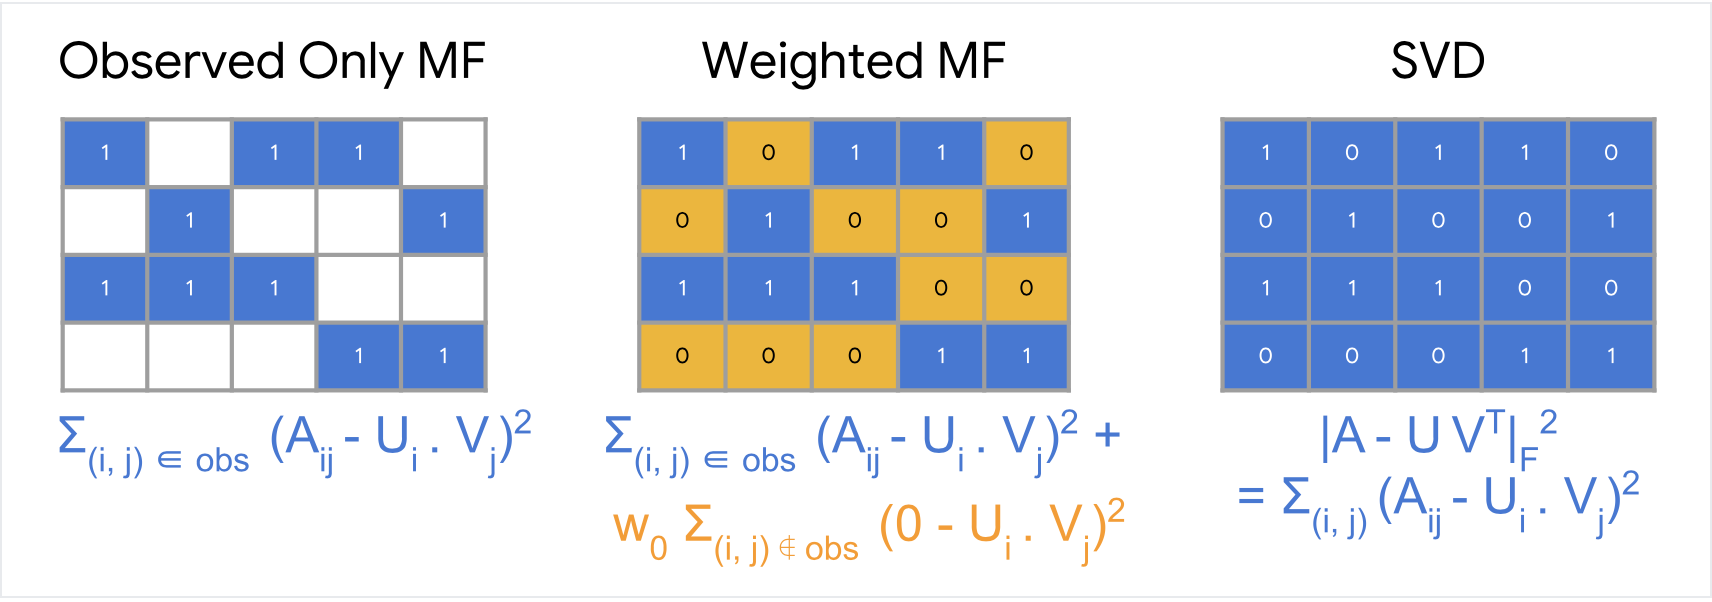

Different objective functions. Source: Google Machine Learning course

Another way would be to initialise the unknown values in the transactions matrix as 0 (as shown in the third picture) and then use singular value decomposition or gradient descent to estimate the two factor matrices. This would also lead to subpar results, however. As the transactions matrix is extremely sparse, an approximation of that matrix with all zeros would have the least loss but still be unable to help us recommend products.

So an acceptable way is to intialise the values for transactions that have not taken place as zero, but reduce the weight of those values while calculating the loss function.

Owing to the size of the data I cannot run the a loss function on all 6bn possible pairs of customers and transactions. Hence, below I try to approximate it by having an equal share of real transactions and transactions that have not taken place.

# Running a model on customer article pairs not part of transactions as well.

In [5]:
#Creating a reference dataframe to help in creating transactions_large

from operator import index
# Creating the larger dataset with non-purchased items as well.

reference_set = (transactions.drop(columns = 
                                   'article_id')).groupby('customer_id').sum()
reference_set['numbers'] = reference_set['numbers'].astype('int16')
reference_set.head()

,numbers
customer_id,
0,21
1,86
2,18
3,2
4,13


In [10]:
# Run this code to create transactions_large

# transactions_large = []
# # total_articles = 104546

# for i in reference_set.index:
#   transactions_large += [[i,j] for j in random.sample(
#       range(0, 104546), reference_set.loc[i]['numbers'])]

# transactions_large = pd.DataFrame(transactions_large).assign(
#     numbers=(np.zeros(len(transactions_large))))
# transactions_large.columns = ['customer_id', 'article_id', 'numbers']
# transactions_large = pd.concat([transactions, transactions_large])
# transactions_large.sort_values(by=['customer_id', 'article_id'],inplace=True)
# transactions_large = transactions_large.groupby(by=
#                                                 ['customer_id','article_id'], 
#                                                 as_index=False, sort=False).sum()
# transactions_large.reset_index(inplace=True, drop=True)

# transactions_large.head()

In [4]:
transactions_large = pd.read_csv(
    '/content/drive/MyDrive/transactions_train_large.csv')
transactions_large.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
test_large = transactions_large.sample(frac=0.05, replace=False, 
                                       random_state=42, axis=0)

In [6]:
# Building the model
a_input2 = keras.Input(shape=(1,))
c_input2 = keras.Input(shape=(1,))

a_embedding2 = keras.layers.Embedding(input_dim=len(
    set(transactions_large.article_id)), output_dim=100)(a_input2)
c_embedding2 = keras.layers.Embedding(input_dim=len(
    set(customers.customer_id)), output_dim=100)(c_input2)

c_reshape2 = keras.layers.Reshape((100,1))(c_embedding2)
a_reshape2 = keras.layers.Reshape((100,1))(a_embedding2)

dot2 = keras.layers.Dot(axes=(1,1))([a_reshape2, c_reshape2])

model2 = keras.models.Model([a_input2, c_input2], dot2)

model2.compile(optimizer=keras.optimizers.Adam(), 
               loss=tf.keras.losses.MeanSquaredError())

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       10454700    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       137198000   ['input_2[0][0]']                
                                                                                              

In [8]:
# Fitting the model
history2 = model2.fit(x=[transactions_large.article_id,
                         transactions_large.customer_id], 
                      y=[transactions_large.numbers], 
                      batch_size=12000, epochs = 30, 
                      validation_data = ([test_large.article_id,
                           test_large.customer_id],test_large.numbers))

Epoch 1/30
4923/4923 [==============================] - 192s 38ms/step - loss: 0.4838 - val_loss: 0.3166
Epoch 2/30
4923/4923 [==============================] - 188s 38ms/step - loss: 0.2925 - val_loss: 0.2184
Epoch 3/30
4923/4923 [==============================] - 188s 38ms/step - loss: 0.2132 - val_loss: 0.1542
Epoch 4/30
4923/4923 [==============================] - 188s 38ms/step - loss: 0.1629 - val_loss: 0.1210
Epoch 5/30
4923/4923 [==============================] - 186s 38ms/step - loss: 0.1338 - val_loss: 0.1025
Epoch 6/30
4923/4923 [==============================] - 187s 38ms/step - loss: 0.1162 - val_loss: 0.0903
Epoch 7/30
4923/4923 [==============================] - 185s 38ms/step - loss: 0.1040 - val_loss: 0.0816
Epoch 8/30
4923/4923 [==============================] - 185s 38ms/step - loss: 0.0949 - val_loss: 0.0750
Epoch 9/30
4923/4923 [==============================] - 185s 38ms/step - loss: 0.0879 - val_loss: 0.0699
Epoch 10/30
4923/4923 [==============================] 

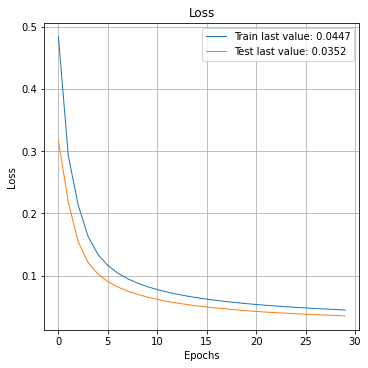

In [11]:
# Plotting out train and test loss

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

In [12]:
# copying embeddings
article_embeddings2 = model2.layers[2].get_weights()[0]
customer_embeddings2 = model2.layers[3].get_weights()[0]

print('Article embeddings \n', article_embeddings2[:5,:5])
print('Customer embeddings \n',customer_embeddings2[:5,:5])

Article embeddings 
 [[-0.93628174  0.3088898  -0.43298754  0.39492518 -0.07139312]
 [-0.46760538 -0.00134005 -0.47072864  0.23171829  0.19578333]
 [-0.41438925  0.38550168 -0.41227254 -0.08830786  0.32539162]
 [-0.04371195  0.17909102 -0.21565704  0.3471363   0.00735251]
 [ 0.01694256  0.3449224  -0.13805597  0.25350705  0.4229925 ]]
Customer embeddings 
 [[-0.2161248  -0.30565387 -0.62935376 -0.03177536  0.02236851]
 [-0.19367099 -0.3141915   0.3445499  -0.12474683 -0.27588597]
 [ 0.06999723  0.09188116 -0.02212605 -0.04120117  0.34742492]
 [-0.09493338  0.06602446 -0.07231845  0.06073087  0.04735655]
 [-0.02875319  0.19613871 -0.04921699  0.14238288  0.03285307]]


In [15]:
#getting predictions from the model, which would be submitted on Kaggle

preds2 = get_predictions(article_embeddings2, 
                        customer_embeddings2, transactions_large)
preds2

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625939021 796046001 111593001 729860002 752814...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,692226004 608458001 658030006 160442043 569984...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,799365002 417951001 456163028 568597006 668537...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,685816002 570002001 160442010 561445005 706016...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,828047002 607642008 561445005 724904002 572797...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,669091001 741806002 722970001 321249009 111609...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,341186001 243613004 721511003 685816019 730946...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,146730001 561445005 400285006 507910004 685813...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,678342028 570002001 499334001 417951001 501616...


# Conclusion and future work

This project has been a brief introduction to recommendation systems. It looks at the concept of matrix factorisation and how this can help make customer and article embeddings which puts the two in a latent space. Then, we can use many ways to compute the distances (such as dot product, cosine distance) between these vectors to see what article is a customer most probable to buy.

The above model is a rudimentary one, and hence, unsurprisingly, gives out weak results. Using the MAP@12 measure described above, the model scores 0.001 (this compares with 0.03 for the top submission). There are a number of things that can be done further to improve the model. The fundamental ones are:
* Create an objective function that weighs all transactions that have not taken place of all possible transactions. Currently, my model doesn't do it owing to computational constraints as there are 6bn such transactions.
* Regularise the embeddings
* Try different embedding sizes
* Trying a deep learning model with softmax output, that can also take in other characteristics of customers and articles

# References

* Google Recommendation Systems course. https://developers.google.com/machine-learning/recommendation
* H&M Personalised Fashion Recommendations. https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview
* Using Singular Value Decomposition to Build a Recommender System, Machine Learning Mastery. https://machinelearningmastery.com/using-singular-value-decomposition-to-build-a-recommender-system/ 
* Gilbert Strang, SVD. https://www.youtube.com/watch?v=rYz83XPxiZo 